In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

import statsmodels.api as sm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR

from skopt.searchcv import BayesSearchCV
from skopt.space import Categorical, Real, Integer

In [2]:
class feature_filter(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        assert type(columns) == list
        self.columns = columns

    def fit(self, X, y=None):
        # No fit functionality
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)

In [3]:
class efficiency_feature(BaseEstimator, TransformerMixin):
    
    def __init__(self, polytropicCompression, temperature="C"):
        self.polytropicCompression = polytropicCompression
        self.temperature = temperature

        if temperature == "C":
            self.temperatureCorrection = 273.15
        else:
            self.temperatureCorrection = 0

    def fit(self, X, y=None):
        # No fit functionality
        return self

    def transform(self, X, y=None):
        CAT = np.array([])
        BCE = np.array([])
        pressure_ratio = X["CDP"] / (X["AP"] / 1000)
        CAT = ((X["AT"] + 273.15) * np.power(pressure_ratio, 0.32)) - 273.15
        efficiency_num = (X["AT"] + 273.15) * ((X["TAT"] + 273.15)/(X["AT"] + 273.15) - 1)
        efficiency_denom = (CAT + 273.15) * ((X["TIT"] + 273.15)/(CAT + 273.15) - 1)
        BCE = 1 - efficiency_num / efficiency_denom
        BCE = pd.Series(BCE, name="BCE", dtype="float64")
        return pd.concat((X, BCE), axis=1)

In [4]:
def evaluator(model_list, fold_of_cv):
    cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, fold_of_cv)])
    coef_of_determination_test = pd.Series(dtype=np.float64)
    MSE_scores_test = pd.Series(dtype=np.float64)

    column_range_for_cv_cols = -3 - fold_of_cv

    for model in tqdm(model_list.keys()):
        temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")
        cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
        
        coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test, y_test)
        y_pred = model_list[model].best_estimator_.predict(X_test)
        MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))


    for model in coef_of_determination_test.index.values:
        print("Test Results:")
        print("{:s} için elde edilen R^2 değeri: {:.4f}".format(model, coef_of_determination_test[model]))
        print("{:s} için elde edilen RMSE değeri: {:.4f}".format(model, MSE_scores_test[model]))
        print("\n" + "*"*50 + "\n")


    sns.boxplot(data=cv_results.melt(), y="variable", x="value")
    plt.show()
    
    cv_results.loc["Mean", :] = cv_results.mean()
    cv_results.loc["Std", :] = cv_results.std()
    display(cv_results)
    return cv_results

In [5]:
def model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_spline=False, use_efficiency=False, use_filter=False, polytropic_compression=0.28, filter_columns=None):
    # Random Forest Random Search
    random_forest_pipeline = Pipeline(steps=[
        ("random_forest", RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=random_state))
    ])

    if use_spline:
        random_forest_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        random_forest_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        random_forest_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "random_forest__n_estimators": np.linspace(5, 350, 7).astype(np.int32),
        "random_forest__max_depth": np.linspace(5, 50, 7).astype(np.int32),
        "random_forest__max_features": np.linspace(0.1, 1, 7),
        "random_forest__min_samples_leaf": np.linspace(1, 20, 5).astype(np.int32)
    }

    random_search_random_forest = RandomizedSearchCV(random_forest_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_random_forest.fit(X_train, y_train)
    display("Random Forest end.")



    # Adaboost Random Search
    adaboost_pipeline = Pipeline(steps=[
    ("adaboost", AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), random_state=random_state))
    ])

    if use_spline:
        adaboost_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        adaboost_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        adaboost_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "adaboost__base_estimator__max_depth": np.linspace(1, 10, 5).astype(np.int32),
        "adaboost__base_estimator__min_samples_leaf": np.linspace(1, 10, 5).astype(np.int32),
        "adaboost__base_estimator__splitter": ["best", "random"],
        "adaboost__n_estimators": np.linspace(5, 300, 5).astype(np.int32),
        "adaboost__loss": ["linear", "square"]
    }

    random_search_adaboost = RandomizedSearchCV(adaboost_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_adaboost.fit(X_train, y_train)
    display("Adaboost end.")
    


    # Histogram Gradient Random Search
    hist_grad_pipeline = Pipeline(steps=[
    ("hist_grad", HistGradientBoostingRegressor())
    ])

    if use_spline:
        hist_grad_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_filter:
        hist_grad_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    if use_efficiency:
        hist_grad_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    param_distributions = {
        "hist_grad__max_iter": np.logspace(2, 4, 3).astype(np.int32),
        "hist_grad__l2_regularization": np.logspace(-1, 3, 5),
        "hist_grad__learning_rate": np.logspace(-3, 2, 6),
        "hist_grad__max_bins": np.logspace(4, 7, 4, base=2).astype(np.int32)
    }

    random_search_hist_grad = RandomizedSearchCV(hist_grad_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
    random_search_hist_grad.fit(X_train, y_train)
    display("Histogram Gradient end.")
    return random_search_random_forest, random_search_adaboost, random_search_hist_grad


In [6]:
def permutation_test_independent(firstSampling, secondSampling, alternative="less"):
    # firstSampling: pd.Series
    # secondSampling: pd.Series
    # Label: string
    # hypothesis: less or greater means first sampling is lesser or greater than second sampling

    numberofPerm = 10000
    firstSamplingLength = len(firstSampling)
    secondSamplingLength = len(secondSampling)
    samplingPool = np.concatenate((firstSampling.values.reshape(-1, 1), secondSampling.values.reshape(-1, 1)), axis=0).ravel()
    labelPool = ["firstLabel" for i in range(firstSamplingLength)]
    labelPool.extend(["secondLabel"] * secondSamplingLength)
    labelPool = np.array(labelPool).ravel()
    
    if alternative == "less":
        observedDifference = np.median(secondSampling) - np.median(firstSampling)
    elif alternative == "greater":
        observedDifference = np.median(firstSampling) - np.median(secondSampling)
    else:
        raise ValueError
    
    permutations = []
    extremePermutations = []

    for i in range(numberofPerm):
        sampledData = np.random.choice(samplingPool, size=(firstSamplingLength + secondSamplingLength), replace=False)
        sampledLabel = np.random.choice(labelPool, size=(firstSamplingLength + secondSamplingLength), replace=False)

        firstSamplingFilter = np.argwhere(sampledLabel == "firstLabel")
        secondSamplingFilter = np.argwhere(sampledLabel == "secondLabel")

        if alternative == "less":
            permutatedDifference = np.median(sampledData[secondSamplingFilter]) - np.median(sampledData[firstSamplingFilter])
        elif alternative == "greater":
            permutatedDifference = np.median(sampledData[firstSamplingFilter]) - np.median(sampledData[secondSamplingFilter])

        extremePermutations.append(permutatedDifference > observedDifference)
        permutations.append(permutatedDifference)

    # ax = sns.histplot(x=permutations)
    # ax.vlines(observedDifference, ymin=0, ymax=1500, color="red")
    # plt.show()
    
    return np.mean(extremePermutations)


In [7]:
#!ls /datasets/personal-gd/Tunahan/Master/VBM/VBM683/Data\ Set

df_2011 = pd.read_csv("Data Set/gt_2011.csv")
df_2012 = pd.read_csv("Data Set/gt_2012.csv")
df_2013 = pd.read_csv("Data Set/gt_2013.csv")
df_2014 = pd.read_csv("Data Set/gt_2014.csv")
df_2015 = pd.read_csv("Data Set/gt_2015.csv")

df = pd.concat([df_2011, df_2012, df_2013, df_2014, df_2015])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36733 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


**Features**
<ul>
<li>AT: Ambient Temperature, C</li>
<li>AP: Ambient Pressure, mbar</li>
<li>AH: Ambient Humidity, %</li>
<li>AFDP: Air Filter Difference Pressure, mbar</li>
<li>GTEP: Gas Turbine Exhaust Pressure, mbar</li>
<li>TIT: Turbine Inlet Temperature, C</li>
<li>TAT: Turbine After Temperature, C</li>
<li>CDP: Compressor Discharge Pressure, bar</li>
<li>TEY: Turbine Energy Yield, MWH</li>
</ul>

**Target**
<ul>
<li>CO: Carbon Monoxide, mg/m3 || ppm</li>
<li>NOx: Nitrogen Oxides, mg/m3 || ppm</li>
</ul>

In [9]:
display(df.shape)
display(df.describe())

(36733, 11)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


100%|██████████| 11/11 [00:01<00:00,  8.60it/s]


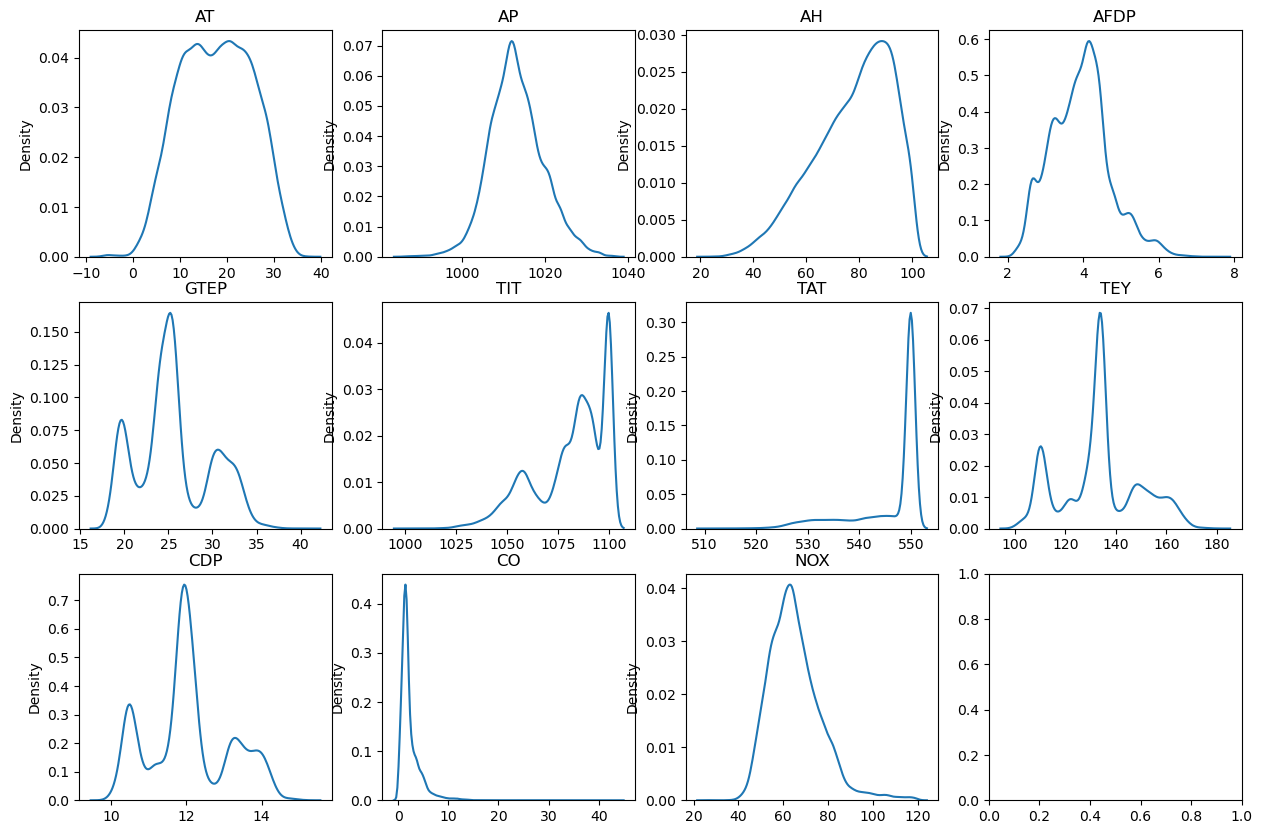

In [10]:
#Her niteliğin dağılımını incele
fig, axes = plt.subplots(ncols=4, nrows=3, sharex=False, sharey=False)

column_list = df.columns.values
for column, ax in zip(tqdm(column_list), np.ravel(axes)):
    sns.kdeplot(data=df, x=column, ax=ax)
    ax.set_xlabel("")
    ax.set_title(column)

fig.set_size_inches(15, 10)

In [11]:
# df["Transformed_NOX"] = np.log(df["NOX"])

# fig, ax = plt.subplots(nrows=2, ncols=2)
# sns.histplot(data=df, x="NOX", ax=ax[0][0])
# sns.histplot(data=df, x="Transformed_NOX", ax=ax[0][1])
# sm.qqplot(df["NOX"], line = "45", fit = True, ax=ax[1][0])
# sm.qqplot(df["Transformed_NOX"], line = "45", fit = True, ax=ax[1][1])
# fig.set_size_inches(10,8)

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


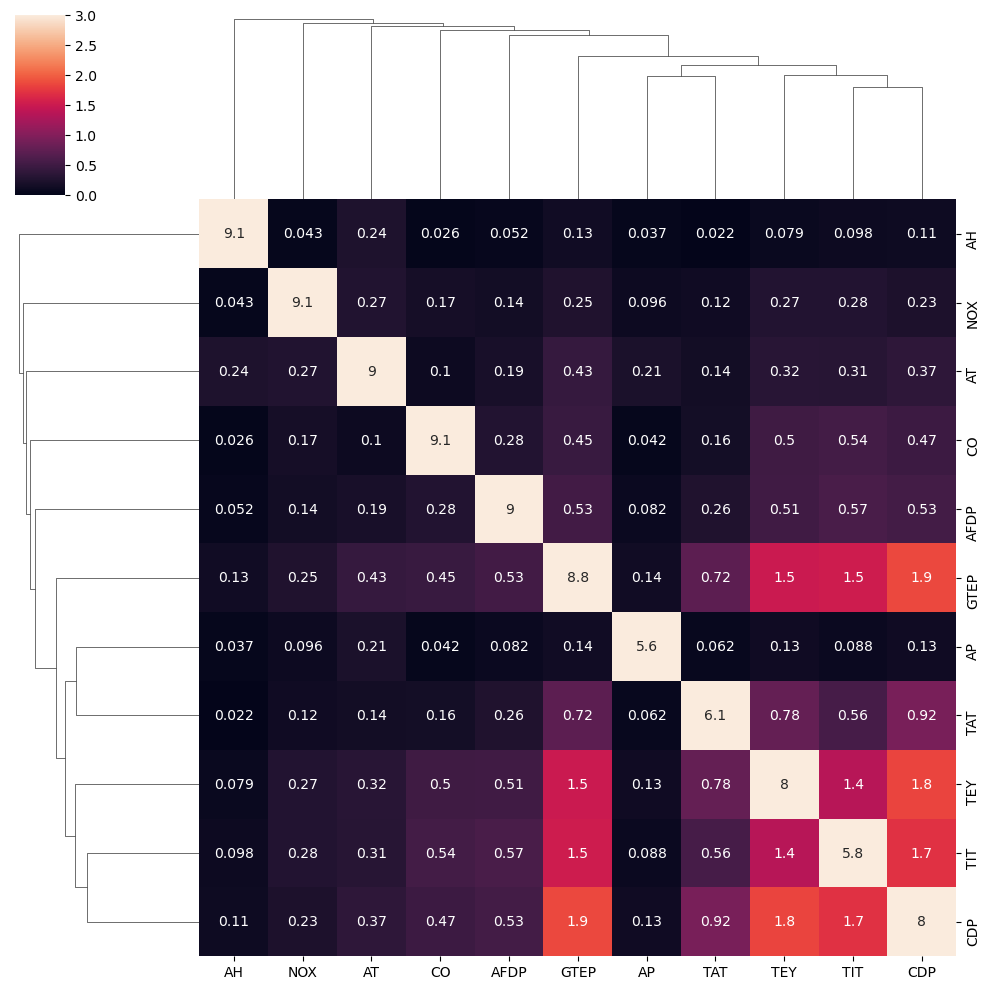

In [12]:
number_of_features = len(df.columns)
correlation_matrix = np.ones((number_of_features, number_of_features))

#Doğrusal ve doğrusal olmayan ilişkileri görmek için mutual_info skorelarını hiyerarşik olarak incele
for row in tqdm(range(number_of_features)):
    for col in range(number_of_features):
        if col > row: #Korelasyon matrisi simetrik olduğu için işlem sadece alt üçgen matris için yapıldı
            continue
        correlation_matrix[row][col] = mutual_info_regression(df.iloc[:, row].values.reshape(-1, 1), df.iloc[:, col].values.ravel())

#Alt üçgen matrisi üst üçgen matrise yapıştır
for row in range(number_of_features):
    for col in range(number_of_features):
        if col < row:
            continue
        correlation_matrix[row][col] = correlation_matrix[col][row]

correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
sns.clustermap(correlation_df, annot=True, vmin=0, vmax=3)

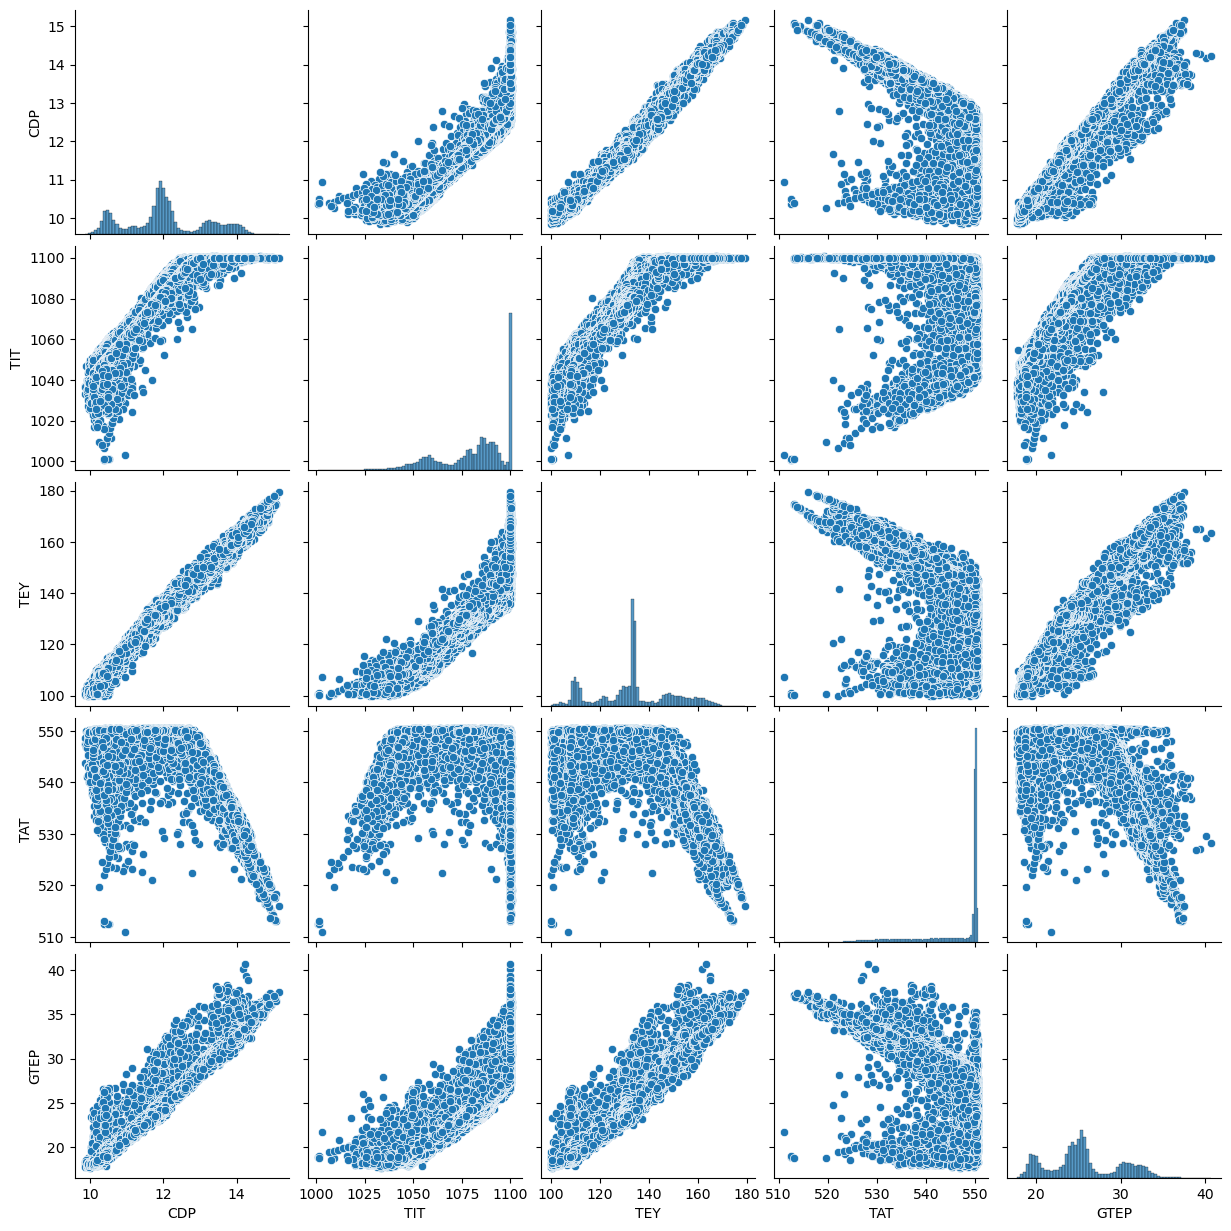

In [13]:
#Mutual_info grafiğinde yer alan kümeleşmeler veriler arasında manalı bir ilişki olabileceğini gösterdi.
#Dolayısıyla pairplot ile ilişkileri görselleştirebiliriz.

selected_features = ["CDP", "TIT", "TEY", "TAT", "GTEP"]
sns.pairplot(data=df[selected_features])

In [14]:
targets = ["NOX", "CO"]
feature_list = np.setdiff1d(column_list, targets)
display(column_list)
display(feature_list)
display(df.loc[:, targets[0]].describe())

X = df.loc[:, feature_list]
y = df.loc[:, targets[0]]
random_state = 2022

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

array(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'], dtype=object)

array(['AFDP', 'AH', 'AP', 'AT', 'CDP', 'GTEP', 'TAT', 'TEY', 'TIT'],
      dtype=object)

count    36733.000000
mean        65.293067
std         11.678357
min         25.905000
25%         57.162000
50%         63.849000
75%         71.548000
max        119.910000
Name: NOX, dtype: float64

In [15]:
%store -r

# Model Type Selection

In [16]:
n_iter = 75 #Iteration count for random search trails
fold_of_cv = 7

In [ ]:
# Decision Tree Grid Search
decision_tree_pipeline = Pipeline(steps=[
    ("decision_tree", DecisionTreeRegressor(random_state=random_state))
])

param_distributions = {
    "decision_tree__max_depth":np.linspace(5, 100, 5).astype(np.int32),
    "decision_tree__min_samples_split":np.linspace(5, 400, 5).astype(np.int32),
    "decision_tree__min_samples_leaf":np.linspace(5, 300, 5).astype(np.int32)
}

random_search_decision_tree = RandomizedSearchCV(decision_tree_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_decision_tree.fit(X_train, y_train)

%store random_search_decision_tree

In [ ]:
# Random Forest Tree Grid Search
random_forest_pipeline = Pipeline(steps=[
    ("random_forest", RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=random_state))
])

param_distributions = {
    "random_forest__n_estimators": np.linspace(5, 350, 7).astype(np.int32),
    "random_forest__max_depth": np.linspace(5, 50, 7).astype(np.int32),
    "random_forest__max_features": np.linspace(0.1, 1, 7),
    "random_forest__min_samples_leaf": np.linspace(1, 20, 5).astype(np.int32)
}

random_search_random_forest = RandomizedSearchCV(random_forest_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_random_forest.fit(X_train, y_train)

%store random_search_random_forest

In [ ]:
# Adaboost Grid Search

adaboost_pipeline = Pipeline(steps=[
    ("adaboost", AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), random_state=random_state))
])

param_distributions = {
    "adaboost__base_estimator__max_depth": np.linspace(1, 10, 5).astype(np.int32),
    "adaboost__base_estimator__min_samples_leaf": np.linspace(1, 10, 5).astype(np.int32),
    "adaboost__base_estimator__splitter": ["best", "random"],
    "adaboost__n_estimators": np.linspace(5, 300, 5).astype(np.int32),
    "adaboost__loss": ["linear", "square"]
}

random_search_adaboost = RandomizedSearchCV(adaboost_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_adaboost.fit(X_train, y_train)

%store random_search_adaboost

In [ ]:
linear_SVR_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linear_SVR", SVR(kernel="linear", cache_size=500))
])

param_distributions = {
    "linear_SVR__tol": np.logspace(-5, -2, 5),
    "linear_SVR__C": np.logspace(-4, 1, 5),
    "linear_SVR__epsilon": np.logspace(-1, 0.5, 5),
}

random_search_linear_SVR = RandomizedSearchCV(linear_SVR_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_linear_SVR.fit(X_train, y_train)

%store random_search_linear_SVR

In [ ]:
rbf_SVR_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("rbf_SVR", SVR(kernel="rbf", cache_size=500))
])

param_distributions = {
    "rbf_SVR__gamma": np.logspace(-7, 3, 5),
    "rbf_SVR__tol": np.logspace(-5, -2, 5),
    "rbf_SVR__C": np.logspace(-4, 1, 5),
    "rbf_SVR__epsilon": np.logspace(-1, 0.5, 5),
}

random_search_rbf_SVR = RandomizedSearchCV(rbf_SVR_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_rbf_SVR.fit(X_train, y_train)

%store random_search_rbf_SVR

In [ ]:
hist_grad_pipeline = Pipeline(steps=[
    ("hist_grad", HistGradientBoostingRegressor())
])

param_distributions = {
    "hist_grad__max_iter": np.logspace(2, 4, 3).astype(np.int32),
    "hist_grad__l2_regularization": np.logspace(-1, 3, 5),
    "hist_grad__learning_rate": np.logspace(-3, 2, 6),
    "hist_grad__max_bins": np.logspace(4, 7, 4, base=2).astype(np.int32)
}

random_search_hist_grad = RandomizedSearchCV(hist_grad_pipeline, param_distributions=param_distributions, scoring="neg_mean_squared_error", cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=2)
random_search_hist_grad.fit(X_train, y_train)

%store random_search_hist_grad

100%|██████████| 6/6 [00:24<00:00,  4.08s/it]


Test Results:
Decision_Tree için elde edilen R^2 değeri: 0.7826
Decision_Tree için elde edilen RMSE değeri: 5.5624

**************************************************

Test Results:
Random_Forest için elde edilen R^2 değeri: 0.8794
Random_Forest için elde edilen RMSE değeri: 4.1427

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.8541
Adaboost için elde edilen RMSE değeri: 4.5569

**************************************************

Test Results:
Linear_SVR için elde edilen R^2 değeri: 0.4633
Linear_SVR için elde edilen RMSE değeri: 8.7391

**************************************************

Test Results:
RBF_SVR için elde edilen R^2 değeri: 0.8225
RBF_SVR için elde edilen RMSE değeri: 5.0249

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.8775
Hist_Grad için elde edilen RMSE değeri: 4.1743

**************************************************



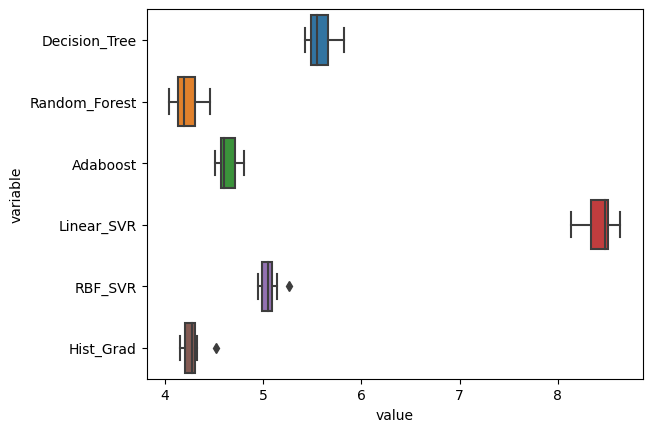

,Decision_Tree,Random_Forest,Adaboost,Linear_SVR,RBF_SVR,Hist_Grad
Split_0_Test_Score,5.755268,4.253035,4.564596,8.636047,5.138615,4.204987
Split_1_Test_Score,5.426924,4.040611,4.573590,8.290594,5.044337,4.326221
Split_2_Test_Score,5.474816,4.182453,4.601187,8.477362,4.984868,4.285487
Split_3_Test_Score,5.550017,4.347548,4.776622,8.549129,5.266049,4.277575
Split_4_Test_Score,5.821730,4.458836,4.806829,8.483166,4.987894,4.517761
Split_5_Test_Score,5.492670,4.088154,4.504492,8.137207,5.047666,4.146670
Split_6_Test_Score,5.554507,4.194850,4.642366,8.392175,4.946186,4.198411
Mean,5.582276,4.223641,4.638526,8.423669,5.059373,4.279587
Std,0.137730,0.134119,0.104508,0.154933,0.102000,0.112607


In [148]:
model_list = {
    "Decision_Tree": random_search_decision_tree,
    "Random_Forest": random_search_random_forest,
    "Adaboost": random_search_adaboost,
    "Linear_SVR": random_search_linear_SVR,
    "RBF_SVR": random_search_rbf_SVR,
    "Hist_Grad": random_search_hist_grad
}

cv_results_model_eval = evaluator(model_list, fold_of_cv)

# Feature Engineering

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


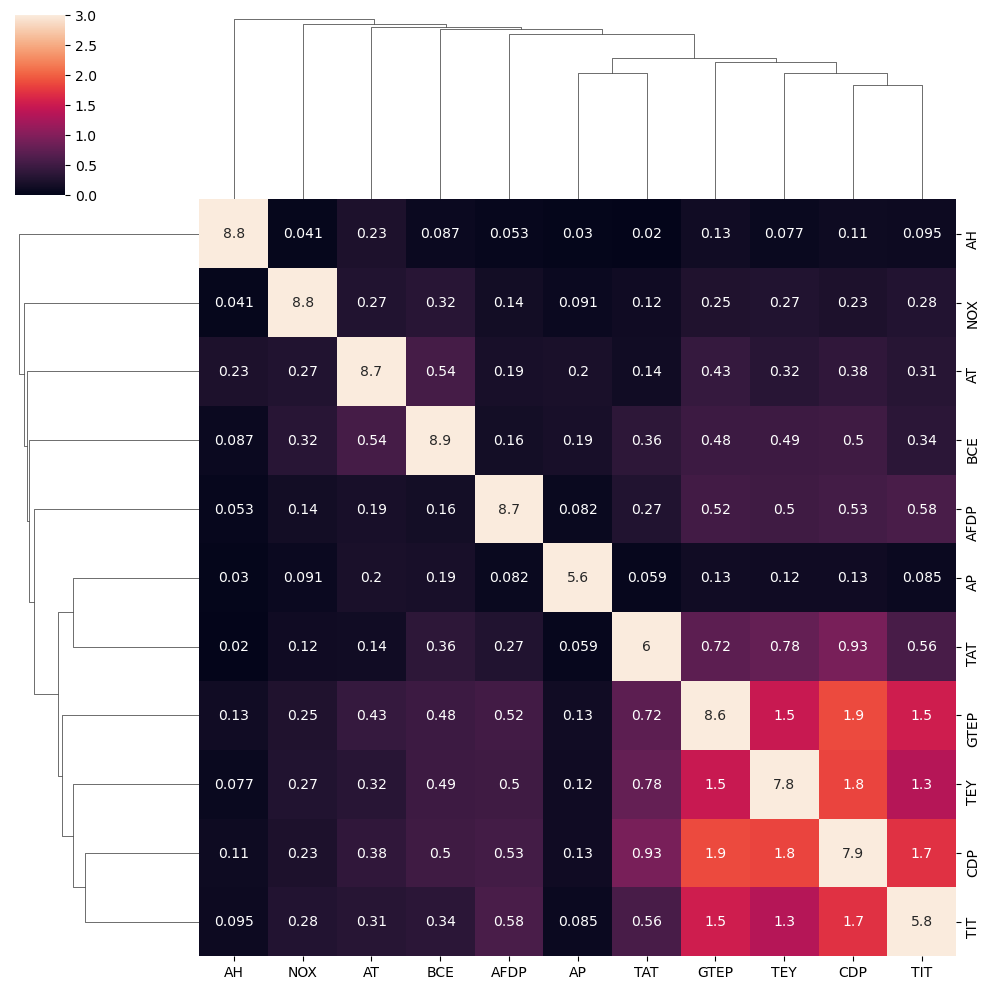

In [32]:
feature_adder = efficiency_feature(0.32)
df = pd.concat((feature_adder.fit_transform(X_train), y_train), axis=1)

number_of_features = len(df.columns)
correlation_matrix = np.ones((number_of_features, number_of_features))

#Doğrusal ve doğrusal olmayan ilişkileri görmek için mutual_info skorelarını hiyerarşik olarak incele
for row in tqdm(range(number_of_features)):
    for col in range(number_of_features):
        if col > row: #Korelasyon matrisi simetrik olduğu için işlem sadece alt üçgen matris için yapıldı
            continue
        correlation_matrix[row][col] = mutual_info_regression(df.iloc[:, row].values.reshape(-1, 1), df.iloc[:, col].values.ravel())

#Alt üçgen matrisi üst üçgen matrise yapıştır
for row in range(number_of_features):
    for col in range(number_of_features):
        if col < row:
            continue
        correlation_matrix[row][col] = correlation_matrix[col][row]

correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
sns.clustermap(correlation_df, annot=True, vmin=0, vmax=3)

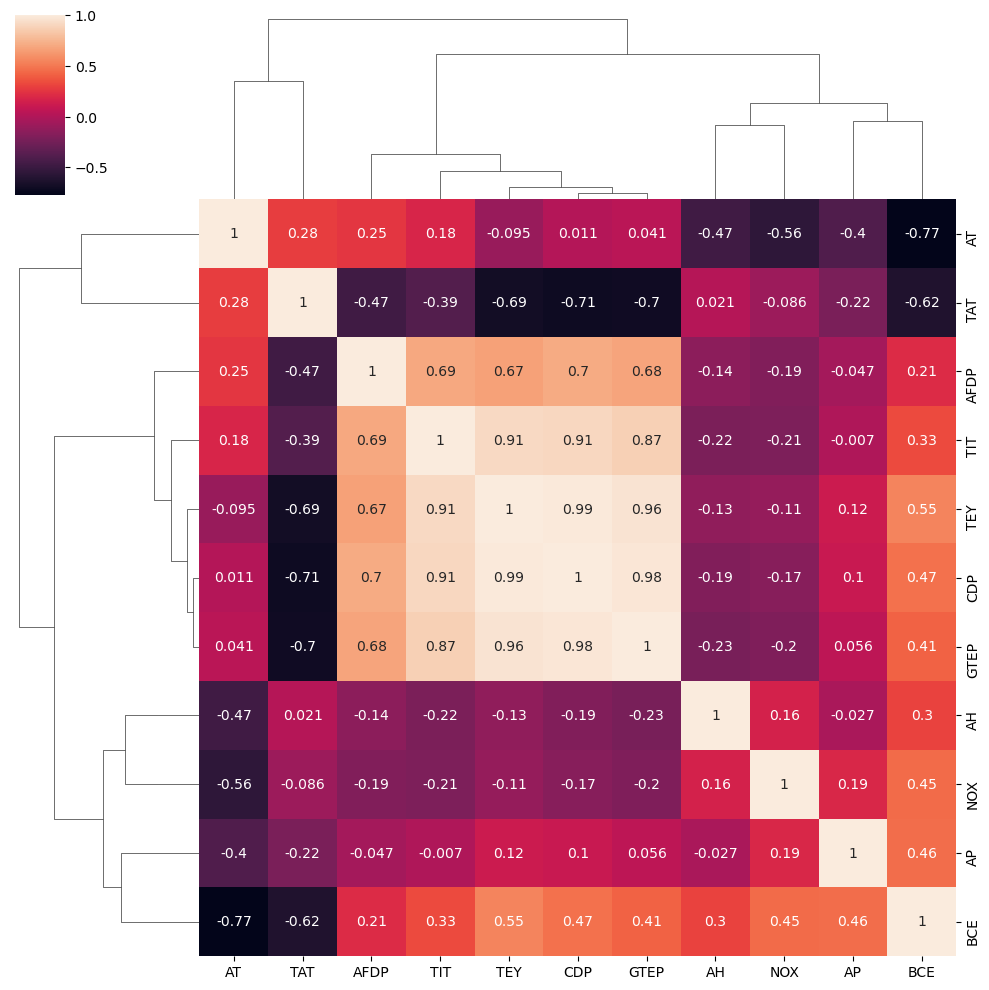

In [33]:
sns.clustermap(df.corr(), annot=True)

In [ ]:
featureEngRF, featureEngAdaboost, featureEngHistGrad = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, polytropic_compression=0.32)

%store featureEngRF
%store featureEngAdaboost
%store featureEngHistGrad

100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

Test Results:
Random_Forest için elde edilen R^2 değeri: 0.8794
Random_Forest için elde edilen RMSE değeri: 4.1427

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.8541
Adaboost için elde edilen RMSE değeri: 4.5569

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.8775
Hist_Grad için elde edilen RMSE değeri: 4.1743

**************************************************

Test Results:
Random_Forest_Feature_Eng için elde edilen R^2 değeri: 0.8813
Random_Forest_Feature_Eng için elde edilen RMSE değeri: 4.1101

**************************************************

Test Results:
Adaboost_Feature_Eng için elde edilen R^2 değeri: 0.8574
Adaboost_Feature_Eng için elde edilen RMSE değeri: 4.5047

**************************************************

Test Results:
Hist_Grad_Feature_Eng için elde edilen R^2 değeri: 0.8806
Hist_Grad_Feature_Eng için elde edilen RMSE değeri: 4.1219

********

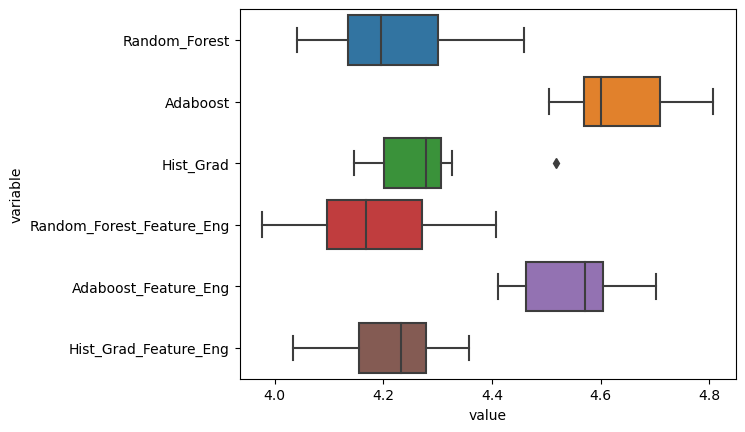

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng
Split_0_Test_Score,4.253035,4.564596,4.204987,4.157465,4.428221,4.084001
Split_1_Test_Score,4.040611,4.573590,4.326221,4.036104,4.497552,4.233057
Split_2_Test_Score,4.182453,4.601187,4.285487,4.241776,4.571326,4.286410
Split_3_Test_Score,4.347548,4.776622,4.277575,4.299413,4.613211,4.228011
Split_4_Test_Score,4.458836,4.806829,4.517761,4.407274,4.700966,4.357677
Split_5_Test_Score,4.088154,4.504492,4.146670,3.976967,4.411512,4.032826
Split_6_Test_Score,4.194850,4.642366,4.198411,4.168174,4.594150,4.271192
Mean,4.223641,4.638526,4.279587,4.183882,4.545277,4.213311
Std,0.134119,0.104508,0.112607,0.137425,0.096949,0.106528


In [149]:
model_list = {
    "Random_Forest": random_search_random_forest,
    "Adaboost": random_search_adaboost,
    "Hist_Grad": random_search_hist_grad,
    "Random_Forest_Feature_Eng": featureEngRF,
    "Adaboost_Feature_Eng": featureEngAdaboost,
    "Hist_Grad_Feature_Eng": featureEngHistGrad
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [43]:
random_forest_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest_Feature_Eng"]]).T
p_value = permutation_test_independent(random_forest_results["Random_Forest_Feature_Eng"], random_forest_results["Random_Forest"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.321'

In [44]:
adaboost_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost_Feature_Eng"]]).T
p_value = permutation_test_independent(adaboost_results["Adaboost_Feature_Eng"], adaboost_results["Adaboost"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.189'

In [45]:
hist_grad_results = pd.DataFrame([cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad_Feature_Eng"]]).T
p_value = permutation_test_independent(hist_grad_results["Hist_Grad_Feature_Eng"], hist_grad_results["Hist_Grad"], alternative="less")
display("Feature engineered results are {} than original dataset. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Feature engineered results are NOT better than original dataset. P-value is 0.271'

## Spline Features

In [ ]:
splineRF, splineAdaboost, splineHistGrad = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, use_spline=True, polytropic_compression=0.32)

%store splineRF
%store splineAdaboost
%store splineHistGrad

100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

Test Results:
Random_Forest için elde edilen R^2 değeri: 0.8794
Random_Forest için elde edilen RMSE değeri: 4.1427

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.8541
Adaboost için elde edilen RMSE değeri: 4.5569

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.8775
Hist_Grad için elde edilen RMSE değeri: 4.1743

**************************************************

Test Results:
Random_Forest_Feature_Eng için elde edilen R^2 değeri: 0.8813
Random_Forest_Feature_Eng için elde edilen RMSE değeri: 4.1101

**************************************************

Test Results:
Adaboost_Feature_Eng için elde edilen R^2 değeri: 0.8574
Adaboost_Feature_Eng için elde edilen RMSE değeri: 4.5047

**************************************************

Test Results:
Hist_Grad_Feature_Eng için elde edilen R^2 değeri: 0.8806
Hist_Grad_Feature_Eng için elde edilen RMSE değeri: 4.1219

********

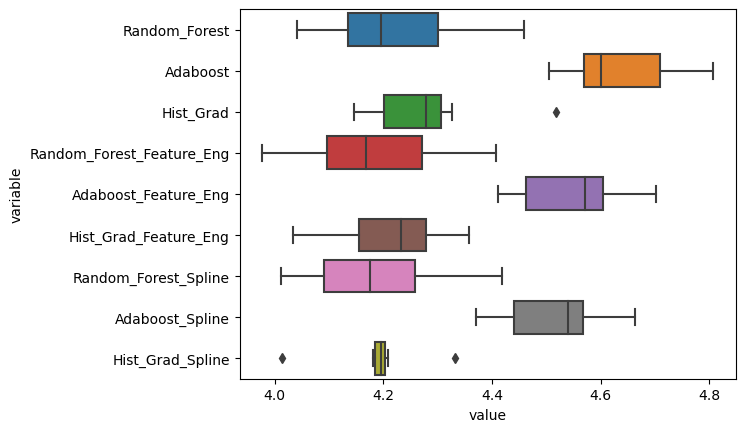

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng,Random_Forest_Spline,Adaboost_Spline,Hist_Grad_Spline
Split_0_Test_Score,4.253035,4.564596,4.204987,4.157465,4.428221,4.084001,4.131308,4.407250,4.180036
Split_1_Test_Score,4.040611,4.573590,4.326221,4.036104,4.497552,4.233057,4.051337,4.473694,4.195537
Split_2_Test_Score,4.182453,4.601187,4.285487,4.241776,4.571326,4.286410,4.218784,4.539804,4.198338
Split_3_Test_Score,4.347548,4.776622,4.277575,4.299413,4.613211,4.228011,4.297513,4.580853,4.208992
Split_4_Test_Score,4.458836,4.806829,4.517761,4.407274,4.700966,4.357677,4.419140,4.663288,4.331258
Split_5_Test_Score,4.088154,4.504492,4.146670,3.976967,4.411512,4.032826,4.011260,4.370753,4.012657
Split_6_Test_Score,4.194850,4.642366,4.198411,4.168174,4.594150,4.271192,4.175215,4.553156,4.189889
Mean,4.223641,4.638526,4.279587,4.183882,4.545277,4.213311,4.186365,4.512685,4.188101
Std,0.134119,0.104508,0.112607,0.137425,0.096949,0.106528,0.130734,0.094478,0.086139


In [21]:
model_list = {
    "Random_Forest": random_search_random_forest,
    "Adaboost": random_search_adaboost,
    "Hist_Grad": random_search_hist_grad,
    "Random_Forest_Feature_Eng": featureEngRF,
    "Adaboost_Feature_Eng": featureEngAdaboost,
    "Hist_Grad_Feature_Eng": featureEngHistGrad,
    "Random_Forest_Spline": splineRF,
    "Adaboost_Spline": splineAdaboost,
    "Hist_Grad_Spline": splineHistGrad
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [19]:
p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest_Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest"], alternative="less")
display("Spline used results are {} than original dataset for Random Forest. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost_Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], alternative="less")
display("Spline used results are {} than original dataset for Adaboost. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad_Spline"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad"], alternative="less")
display("Spline used results are {} than original dataset for Hist Grad. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Spline used results are NOT better than original dataset for Random Forest. P-value is 0.322'

'Spline used results are NOT better than original dataset for Adaboost. P-value is 0.069'

'Spline used results are better than original dataset for Hist Grad. P-value is 0.048'

# Feature Selection

In [87]:
featureEngHistGrad.best_estimator_.steps[1][1]

HistGradientBoostingRegressor(l2_regularization=10.0, max_bins=64,
                              max_iter=10000)

In [88]:
best_model = featureEngHistGrad.best_estimator_.steps[1][1]
transformer = efficiency_feature(0.32)
importance_analysis = permutation_importance(best_model, transformer.fit_transform(X_train), y_train, n_repeats=n_iter, n_jobs=-3, scoring="neg_mean_squared_error", random_state=random_state)

%store importance_analysis

Stored 'importance_analysis' (Bunch)


,Feature_name,Feature_importance_mean,Feature_importance_std
2,AP,13.340316,0.147058
4,CDP,20.896565,0.196525
1,AH,21.005819,0.197360
0,AFDP,22.603629,0.214554
8,TIT,23.180522,0.361079
7,TEY,33.079408,0.267748
6,TAT,33.624315,0.349808
5,GTEP,53.409042,0.686859
9,BCE,63.543897,0.484462
3,AT,66.494365,0.607656


<BarContainer object of 10 artists>

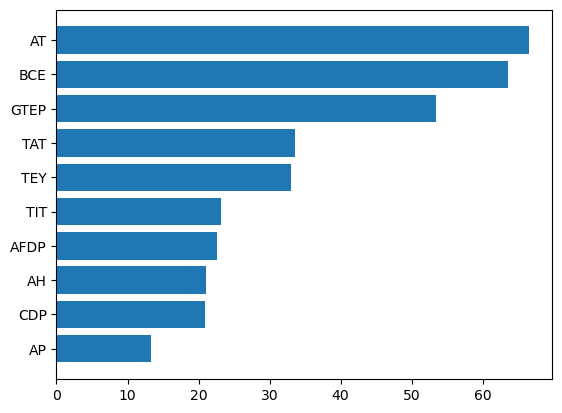

In [90]:
importance_analysis_df = pd.DataFrame(
    {
        "Feature_name": transformer.fit_transform(X_train).columns,
        "Feature_importance_mean": importance_analysis.importances_mean,
        "Feature_importance_std": importance_analysis.importances_std
    }
).sort_values(by="Feature_importance_mean")
display(importance_analysis_df)

fig, ax = plt.subplots()
ax.barh(y=importance_analysis_df.Feature_name, width=importance_analysis_df.Feature_importance_mean)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.3min
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  3.3min finished


Text(0.5, 0.98, '')

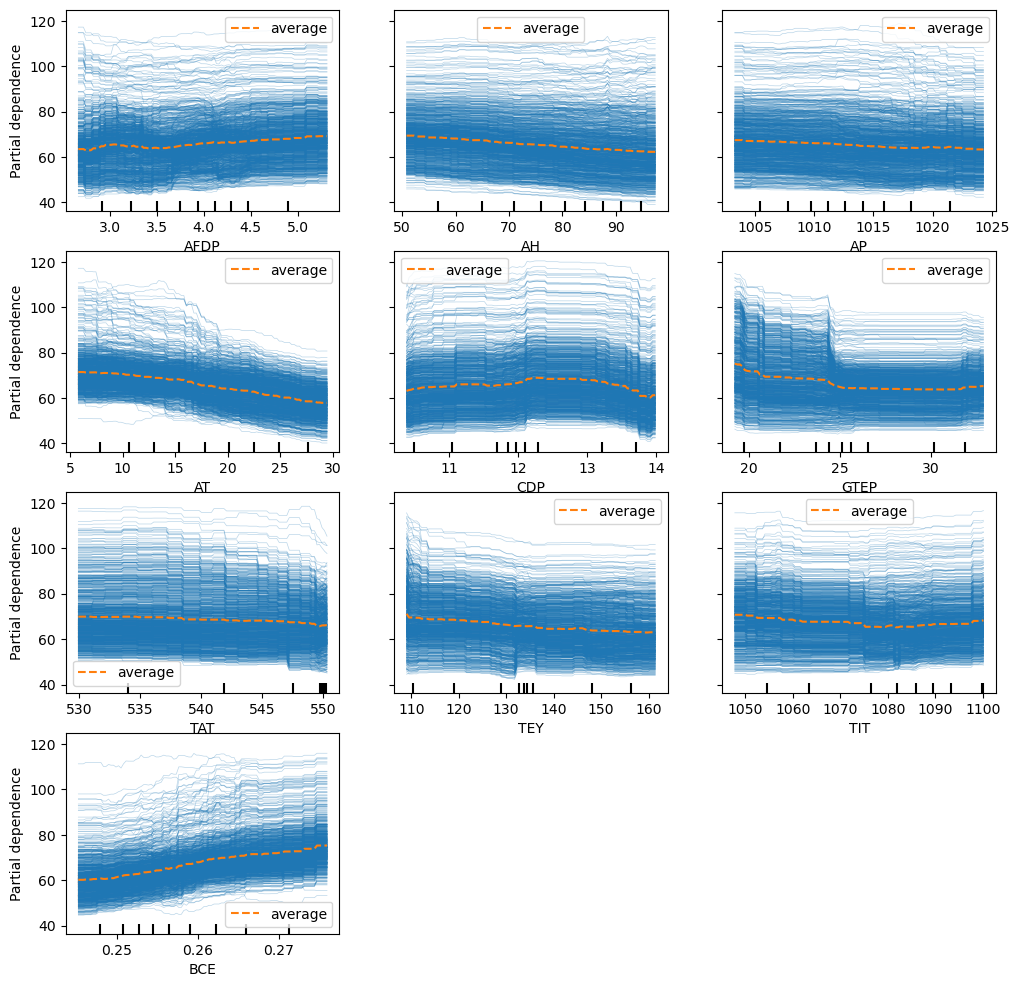

In [91]:
fig, ax = plt.subplots()
plotter = PartialDependenceDisplay.from_estimator(best_model, transformer.fit_transform(X_train), [i for i in range(len(transformer.fit_transform(X_train).columns))], n_jobs=-3, verbose=3, ax=ax, kind="both", random_state=random_state)

for ax, feature in zip(plotter.axes_.ravel(), transformer.fit_transform(X_train).columns):
    ax.set_xlabel(feature)

fig.set_size_inches(12, 12)
fig.suptitle("")

In [ ]:
filterRF, filterAdaboost, filterHistGrad = model_random_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_filter=True, filter_columns=["AP"], use_spline=True, use_efficiency=True, polytropic_compression=0.32)

%store filterRF
%store filterAdaboost
%store filterHistGrad

100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Test Results:
Random_Forest için elde edilen R^2 değeri: 0.8794
Random_Forest için elde edilen RMSE değeri: 4.1427

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.8541
Adaboost için elde edilen RMSE değeri: 4.5569

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.8775
Hist_Grad için elde edilen RMSE değeri: 4.1743

**************************************************

Test Results:
Random_Forest_Feature_Eng için elde edilen R^2 değeri: 0.8813
Random_Forest_Feature_Eng için elde edilen RMSE değeri: 4.1101

**************************************************

Test Results:
Adaboost_Feature_Eng için elde edilen R^2 değeri: 0.8574
Adaboost_Feature_Eng için elde edilen RMSE değeri: 4.5047

**************************************************

Test Results:
Hist_Grad_Feature_Eng için elde edilen R^2 değeri: 0.8806
Hist_Grad_Feature_Eng için elde edilen RMSE değeri: 4.1219

********

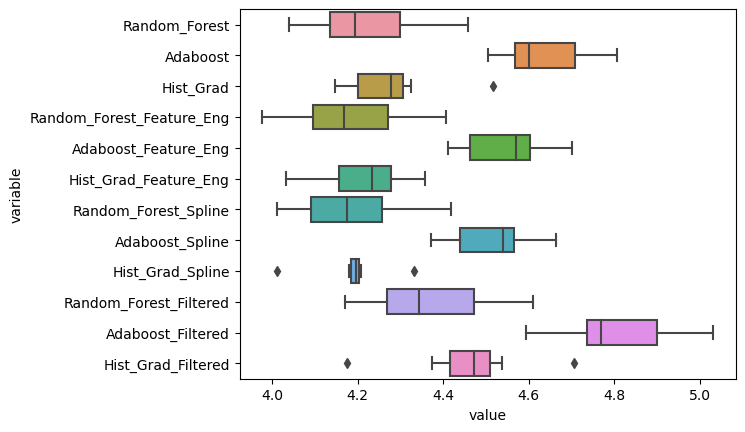

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng,Random_Forest_Spline,Adaboost_Spline,Hist_Grad_Spline,Random_Forest_Filtered,Adaboost_Filtered,Hist_Grad_Filtered
Split_0_Test_Score,4.253035,4.564596,4.204987,4.157465,4.428221,4.084001,4.131308,4.407250,4.180036,4.342962,4.719382,4.479309
Split_1_Test_Score,4.040611,4.573590,4.326221,4.036104,4.497552,4.233057,4.051337,4.473694,4.195537,4.222160,4.769798,4.374533
Split_2_Test_Score,4.182453,4.601187,4.285487,4.241776,4.571326,4.286410,4.218784,4.539804,4.198338,4.420329,4.831201,4.458572
Split_3_Test_Score,4.347548,4.776622,4.277575,4.299413,4.613211,4.228011,4.297513,4.580853,4.208992,4.526744,4.967703,4.538621
Split_4_Test_Score,4.458836,4.806829,4.517761,4.407274,4.700966,4.357677,4.419140,4.663288,4.331258,4.609512,5.031818,4.705283
Split_5_Test_Score,4.088154,4.504492,4.146670,3.976967,4.411512,4.032826,4.011260,4.370753,4.012657,4.169512,4.594851,4.176258
Split_6_Test_Score,4.194850,4.642366,4.198411,4.168174,4.594150,4.271192,4.175215,4.553156,4.189889,4.315997,4.754927,4.471337
Mean,4.223641,4.638526,4.279587,4.183882,4.545277,4.213311,4.186365,4.512685,4.188101,4.372459,4.809955,4.457702
Std,0.134119,0.104508,0.112607,0.137425,0.096949,0.106528,0.130734,0.094478,0.086139,0.146446,0.138189,0.148625


In [21]:
model_list = {
    "Random_Forest": random_search_random_forest,
    "Adaboost": random_search_adaboost,
    "Hist_Grad": random_search_hist_grad,
    "Random_Forest_Feature_Eng": featureEngRF,
    "Adaboost_Feature_Eng": featureEngAdaboost,
    "Hist_Grad_Feature_Eng": featureEngHistGrad,
    "Random_Forest_Spline": splineRF,
    "Adaboost_Spline": splineAdaboost,
    "Hist_Grad_Spline": splineHistGrad,
    "Random_Forest_Filtered": filterRF,
    "Adaboost_Filtered": filterAdaboost,
    "Hist_Grad_Filtered": filterHistGrad
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

In [50]:
p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Random_Forest"], alternative="less")
display("Spline used results are {} than original dataset for Random Forest. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Adaboost"], alternative="less")
display("Spline used results are {} than original dataset for Adaboost. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

p_value = permutation_test_independent(cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad_Filtered"], cv_results_efficiency.drop(labels=["Mean", "Std"], axis=0)["Hist_Grad"], alternative="less")
display("Spline used results are {} than original dataset for Hist Grad. P-value is {:.3f}".format("better" if p_value < 0.05 else "NOT better", p_value))

'Spline used results are NOT better than original dataset for Random Forest. P-value is 0.874'

'Spline used results are NOT better than original dataset for Adaboost. P-value is 0.893'

'Spline used results are NOT better than original dataset for Hist Grad. P-value is 0.924'

# Bayesian Search CV

In [19]:
def model_bayes_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_spline=False, use_efficiency=False, use_filter=False, polytropic_compression=0.28, filter_columns=None, metric="neg_mean_squared_error"):
     # Histogram Gradient Random Search
    hist_grad_pipeline = Pipeline(steps=[
    ("hist_grad", HistGradientBoostingRegressor())
    ])

    if use_spline:
        hist_grad_pipeline.steps.insert(0, ("spline", SplineTransformer()))

    if use_efficiency:
        hist_grad_pipeline.steps.insert(0, ("eff_addition", efficiency_feature(polytropic_compression)))

    if use_filter:
        hist_grad_pipeline.steps.insert(0, ("filter", feature_filter(filter_columns)))

    param_distributions = {
        "hist_grad__max_iter": Integer(1e2, 1e4, "log-uniform"),
        "hist_grad__l2_regularization": Real(1e-1, 1e3, "log-uniform"),
        "hist_grad__learning_rate": Real(1e-3, 1e2, "log-uniform"),
        "hist_grad__max_bins": Integer(2**4, 2**7, "log-uniform", base=2)
    }

    bayes_search_hist_grad = BayesSearchCV(hist_grad_pipeline, search_spaces=param_distributions, scoring=metric, cv=fold_of_cv, n_jobs=-1, n_iter=n_iter, random_state=random_state, verbose=1)
    bayes_search_hist_grad.fit(X_train, y_train)
    display("Histogram Gradient end.")
    return bayes_search_hist_grad


In [20]:
bayes_search_hist_grad = model_bayes_searcher(X_train, y_train, fold_of_cv, n_iter, random_state, use_efficiency=True, use_spline=True, polytropic_compression=0.32)

%store bayes_search_hist_grad

Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fi

'Histogram Gradient end.'

Stored 'bayes_search_hist_grad' (BayesSearchCV)


In [24]:
splineHistGrad.best_params_

{'hist_grad__max_iter': 10000,
 'hist_grad__max_bins': 64,
 'hist_grad__learning_rate': 0.1,
 'hist_grad__l2_regularization': 10.0}

In [25]:
bayes_search_hist_grad.best_params_

OrderedDict([('hist_grad__l2_regularization', 1.8602709629229568),
             ('hist_grad__learning_rate', 0.01071184421343428),
             ('hist_grad__max_bins', 30),
             ('hist_grad__max_iter', 6102)])

100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


Test Results:
Random_Forest için elde edilen R^2 değeri: 0.8794
Random_Forest için elde edilen RMSE değeri: 4.1427

**************************************************

Test Results:
Adaboost için elde edilen R^2 değeri: 0.8541
Adaboost için elde edilen RMSE değeri: 4.5569

**************************************************

Test Results:
Hist_Grad için elde edilen R^2 değeri: 0.8775
Hist_Grad için elde edilen RMSE değeri: 4.1743

**************************************************

Test Results:
Random_Forest_Spline için elde edilen R^2 değeri: 0.8809
Random_Forest_Spline için elde edilen RMSE değeri: 4.1169

**************************************************

Test Results:
Adaboost_Spline için elde edilen R^2 değeri: 0.8592
Adaboost_Spline için elde edilen RMSE değeri: 4.4752

**************************************************

Test Results:
Hist_Grad_Spline için elde edilen R^2 değeri: 0.8814
Hist_Grad_Spline için elde edilen RMSE değeri: 4.1076

**************************************

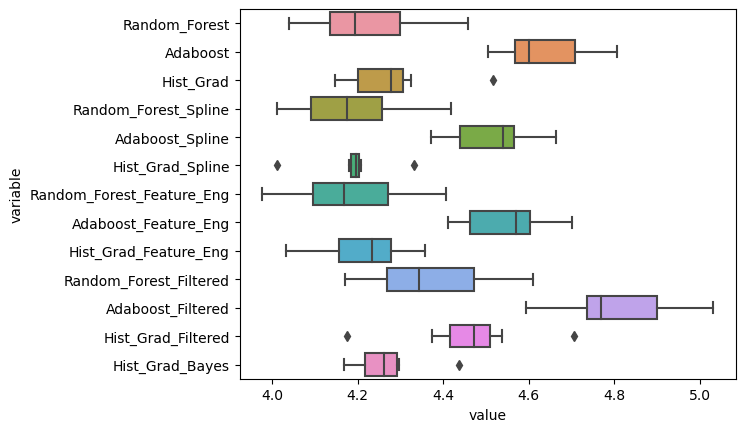

,Random_Forest,Adaboost,Hist_Grad,Random_Forest_Spline,Adaboost_Spline,Hist_Grad_Spline,Random_Forest_Feature_Eng,Adaboost_Feature_Eng,Hist_Grad_Feature_Eng,Random_Forest_Filtered,Adaboost_Filtered,Hist_Grad_Filtered,Hist_Grad_Bayes
Split_0_Test_Score,4.253035,4.564596,4.204987,4.131308,4.407250,4.180036,4.157465,4.428221,4.084001,4.342962,4.719382,4.479309,4.173724
Split_1_Test_Score,4.040611,4.573590,4.326221,4.051337,4.473694,4.195537,4.036104,4.497552,4.233057,4.222160,4.769798,4.374533,4.262164
Split_2_Test_Score,4.182453,4.601187,4.285487,4.218784,4.539804,4.198338,4.241776,4.571326,4.286410,4.420329,4.831201,4.458572,4.260510
Split_3_Test_Score,4.347548,4.776622,4.277575,4.297513,4.580853,4.208992,4.299413,4.613211,4.228011,4.526744,4.967703,4.538621,4.289077
Split_4_Test_Score,4.458836,4.806829,4.517761,4.419140,4.663288,4.331258,4.407274,4.700966,4.357677,4.609512,5.031818,4.705283,4.436514
Split_5_Test_Score,4.088154,4.504492,4.146670,4.011260,4.370753,4.012657,3.976967,4.411512,4.032826,4.169512,4.594851,4.176258,4.169235
Split_6_Test_Score,4.194850,4.642366,4.198411,4.175215,4.553156,4.189889,4.168174,4.594150,4.271192,4.315997,4.754927,4.471337,4.297849
Mean,4.223641,4.638526,4.279587,4.186365,4.512685,4.188101,4.183882,4.545277,4.213311,4.372459,4.809955,4.457702,4.269867
Std,0.134119,0.104508,0.112607,0.130734,0.094478,0.086139,0.137425,0.096949,0.106528,0.146446,0.138189,0.148625,0.083187


In [23]:
model_list = {
    "Random_Forest": random_search_random_forest,
    "Adaboost": random_search_adaboost,
    "Hist_Grad": random_search_hist_grad,
    "Random_Forest_Spline": splineRF,
    "Adaboost_Spline": splineAdaboost,
    "Hist_Grad_Spline": splineHistGrad,
    "Random_Forest_Feature_Eng": featureEngRF,
    "Adaboost_Feature_Eng": featureEngAdaboost,
    "Hist_Grad_Feature_Eng": featureEngHistGrad,
    "Random_Forest_Filtered": filterRF,
    "Adaboost_Filtered": filterAdaboost,
    "Hist_Grad_Filtered": filterHistGrad,
    "Hist_Grad_Bayes": bayes_search_hist_grad
}

cv_results_efficiency = evaluator(model_list, fold_of_cv)

# Model Results

,True_values,Predicted_values,Residuals
count,11020.000000,11020.000000,11020.000000
mean,65.388733,65.333618,0.055115
std,11.929076,10.985415,4.107455
min,27.765000,42.492584,-33.386476
25%,57.139750,57.508881,-1.975103
50%,63.887000,64.148079,-0.087231
75%,71.587500,71.093794,1.814549
max,119.890000,115.170865,45.396667


4.107638828392009

,True_values,Predicted_values,Residuals
1348,78.467,60.967363,17.499637
4294,89.757,72.074372,17.682628
7022,94.436,76.685620,17.750380
486,80.255,62.469673,17.785327
5759,89.291,71.468141,17.822859
6224,93.511,75.214500,18.296500
7354,111.420,93.089676,18.330324
7281,116.460,98.032123,18.427877
2238,86.137,67.352708,18.784292
5629,85.179,66.370907,18.808093


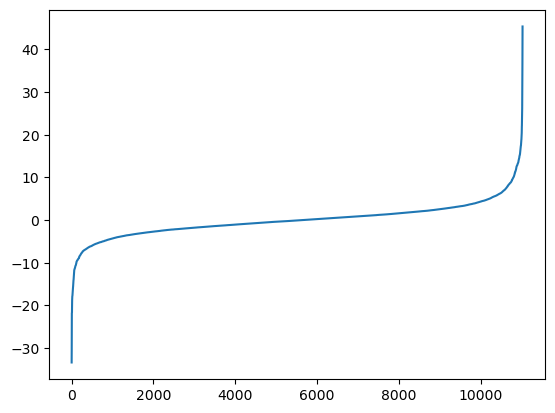

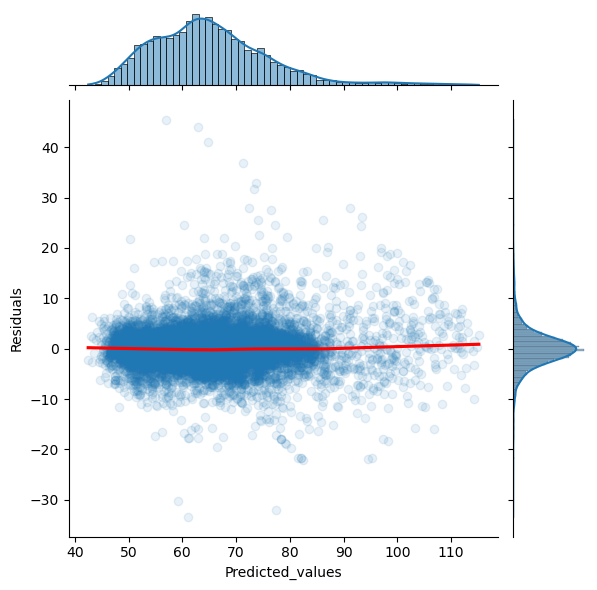

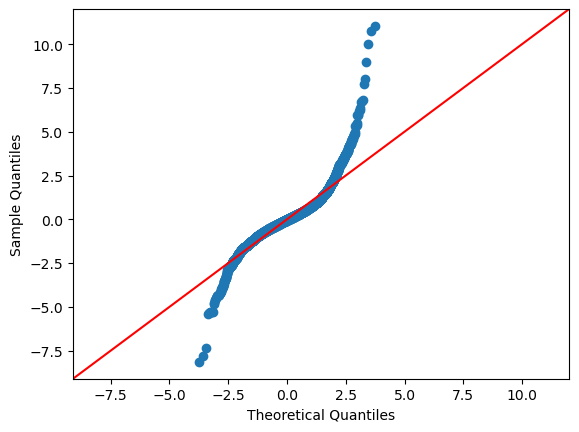

In [27]:
best_model = splineHistGrad.best_estimator_
results_df = pd.DataFrame({
    "True_values": y_test,
    "Predicted_values": best_model.predict(X_test),
})

results_df = results_df.assign(
    Residuals=(results_df.True_values.values - results_df.Predicted_values.values)
    )

display(results_df.describe())
display(np.sqrt(MSE(results_df.True_values, results_df.Predicted_values)))
display(results_df.sort_values(by="Residuals").tail(40))

sns.lineplot(x=range(len(results_df)), y=results_df.sort_values(by="Residuals").Residuals.values)
plt.show()

sns.jointplot(data=results_df, x="Predicted_values", y="Residuals", kind="reg", joint_kws={"lowess":True, "line_kws":{"color": "red"}, "scatter_kws":{"alpha": 0.1}})
plt.show()

sm.qqplot(results_df.Residuals, line="45", fit=True)
plt.show()